# Importando dados

In [ ]:
!pip install graphviz==0.9
!pip install pydot
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [ ]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


# Aula 01 - Randomized Search e Cross validation combinadas

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold

SEED = 301
np.random.seed(SEED)

parametros = {
    'max_depth' : [3,5],
    'min_samples_leaf' : [32,64,128],
    'min_samples_split' : [32,64,128],
    'criterion' : ['gini', 'entropy']
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), parametros, n_iter=16, cv = KFold(n_splits=5, shuffle=True), random_state=SEED)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013585,0.001063,0.001675,0.000295,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.784,0.769,0.7985,0.793,0.7730,0.7835,0.011278,13
1,0.009547,0.000083,0.001430,0.000042,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
2,0.009549,0.000183,0.001392,0.000012,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
3,0.019406,0.000098,0.001521,0.000019,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7
4,0.019578,0.000354,0.001513,0.000021,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7


In [ ]:
print(busca.best_params_)
print(busca.best_score_)
print(busca.best_estimator_)
melhor = busca.best_estimator_

{'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 3, 'criterion': 'gini'}
0.787
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=64,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [ ]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [ ]:
from sklearn.model_selection import cross_val_score

results_1 = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(results_1)

#Resultados do modelo do curso anterior utilizando GridSearchCV
#Accuracy médio 78.67
#Intervalo [76.80, 80.54]

Accuracy médio 78.71
Intervalo [77.49, 79.93]


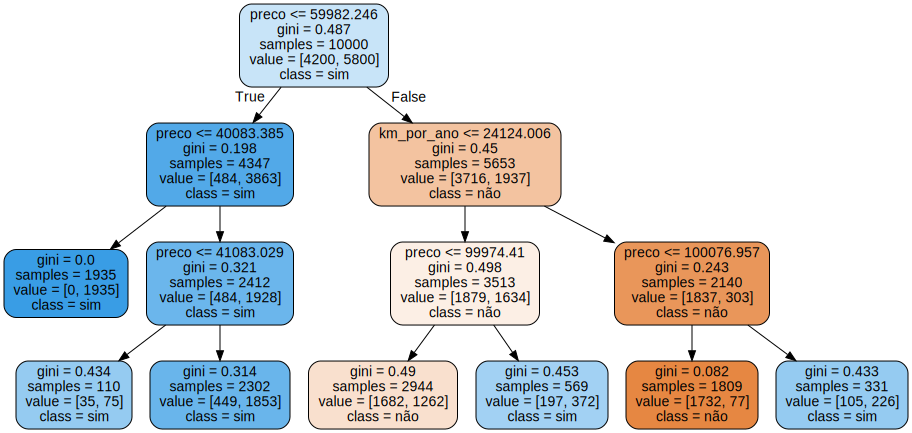

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)
graph = graphviz.Source(dot_data)
graph

#Aula 02 - Explorando por mais tempo espaços maiores

In [ ]:
from scipy.stats import randint

SEED = 301
np.random.seed(SEED)

parametros = {
    'max_depth' : [3,5,10,15,20,30,None],
    'min_samples_leaf' : randint(32,128),
    'min_samples_split' : randint(32,128),
    'criterion' : ['gini', 'entropy']
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), parametros, n_iter=16, cv = KFold(n_splits=5, shuffle=True), random_state=SEED)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01527,0.002105,0.001752,0.000375,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [ ]:
ordenados = resultados.sort_values('mean_test_score', ascending=False).head()
for indice, lista in ordenados.iterrows():
    print("%.3f [%.3f] %s" % (lista.mean_test_score*100, lista.std_test_score*2, lista.params))
melhor = busca.best_estimator_

78.700 [0.019] {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
78.390 [0.024] {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
78.390 [0.024] {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
78.100 [0.017] {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
78.040 [0.019] {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}


In [ ]:
results_2 = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(results_2)

#Resultados do modelo anterior utilizando RandomizedSearchCV com menos parâmetros
#Accuracy médio 78.71
#Intervalo [77.49, 79.93]

Accuracy médio 78.71
Intervalo [77.49, 79.93]


In [ ]:
SEED = 596
np.random.seed(SEED)

parametros = {
    'max_depth' : [3,5,10,15,20,30,None],
    'min_samples_leaf' : randint(32,128),
    'min_samples_split' : randint(32,128),
    'criterion' : ['gini', 'entropy']
}

#Trocando o n_iter de 16 para 64 combinações
busca = RandomizedSearchCV(DecisionTreeClassifier(), parametros, n_iter=64, cv = KFold(n_splits=5, shuffle=True), random_state=SEED)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)

In [ ]:
resultados.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.037926,0.006377,0.001696,0.000074,entropy,30,35,84,"{'criterion': 'entropy', 'max_depth': 30, 'min...",0.7815,0.7685,0.765,0.764,0.7845,0.7727,0.008594,63


In [ ]:
ordenados = resultados.sort_values('mean_test_score', ascending=False).head()
for indice, lista in ordenados.iterrows():
    print("%.3f [%.3f] %s" % (lista.mean_test_score*100, lista.std_test_score*2, lista.params))
melhor = busca.best_estimator_

78.690 [0.015] {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 35, 'min_samples_split': 73}
78.690 [0.015] {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 55, 'min_samples_split': 79}
78.690 [0.015] {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 95, 'min_samples_split': 105}
78.690 [0.015] {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 47, 'min_samples_split': 118}
78.690 [0.015] {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 41, 'min_samples_split': 97}


In [ ]:
results_3 = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(results_3)

#Resultados do modelo anterior con n_iter = 16
#Accuracy médio 78.71
#Intervalo [77.49, 79.93]

#Abaixo, resultado com n_iter = 64

Accuracy médio 78.69
Intervalo [78.03, 79.35]


# Aula 03 - Baseline com busca exaustiva no espaço discretizado

In [ ]:
from sklearn.model_selection import GridSearchCV
import time

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

tic = time.time()
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 215.43 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.039774,0.003669,0.003788,0.000190,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.353825,0.009117,0.020152,0.000379,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.039867,0.001132,0.003986,0.000330,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.354313,0.014087,0.020511,0.000264,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.039230,0.001376,0.003834,0.000103,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


In [ ]:
ordenados = resultados.sort_values('mean_test_score', ascending=False).head()
for indice, lista in ordenados.iterrows():
    print("%.3f [%.3f] %s" % (lista.mean_test_score*100, lista.std_test_score*2, lista.params))

78.010 [0.020] {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
77.840 [0.020] {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
77.820 [0.030] {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
77.790 [0.027] {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
77.760 [0.033] {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


> É possivel observar que o RandomizedSearchCV pode buscar um resultado bem próximo ao GridSearchCV para esse conjunto de dados, além de demorar bem menos tempo como pode-se ver abaixo

# Aula 04 - Comparando com Busca aleatória

In [ ]:
SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" :randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 80,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 110.02 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.372144,0.005756,0.018802,0.000561,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7715,0.7620,0.7750,0.7855,0.7580,0.7704,0.009744,75
1,0.299124,0.006691,0.018595,0.002362,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7575,0.7925,0.7855,0.7575,0.7729,0.014277,63
2,0.278988,0.006675,0.016813,0.000378,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7685,0.7695,0.7925,0.7795,0.7575,0.7735,0.011781,59
3,0.184563,0.004287,0.011971,0.000419,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7670,0.7830,0.7865,0.7580,0.7733,0.010429,60
4,0.282731,0.004928,0.016143,0.000327,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7685,0.7930,0.7850,0.7585,0.7754,0.012220,30


In [ ]:
ordenados = resultados.sort_values('mean_test_score', ascending=False).head()
for indice, lista in ordenados.iterrows():
    print("%.3f [%.3f] %s" % (lista.mean_test_score*100, lista.std_test_score*2, lista.params))

77.900 [0.025] {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 84, 'min_samples_split': 89, 'n_estimators': 48}
77.850 [0.031] {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 96, 'n_estimators': 18}
77.790 [0.032] {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 121, 'min_samples_split': 47, 'n_estimators': 27}
77.750 [0.024] {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 96, 'min_samples_split': 98, 'n_estimators': 11}
77.710 [0.029] {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 63, 'min_samples_split': 88, 'n_estimators': 69}


# Aula 05 - Otimização de hiper parâmetros sem validação cruzada (treino, teste e validação)

In [ ]:
# 0.6 treino     => treino
# 0.2 teste      => dev teste
# 0.2 validacao  => validacao

from sklearn.model_selection import train_test_split

SEED=301
np.random.seed(SEED)

x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar, test_size=0.2, shuffle=True, stratify=y_azar)
print(x_treino_teste.shape)
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

espaco_de_parametros = {
    "n_estimators" :randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25) # 0.25 dos 0.8 que foram separados são 20% do total de dados

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 5,
                    cv = split)
busca.fit(x_treino_teste, y_treino_teste)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 1.07 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.089749,0.0,0.007484,0.0,True,gini,5,89,58,24,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7885,0.7885,0.0,3
1,0.135133,0.0,0.006995,0.0,False,entropy,3,71,55,27,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7920,0.7920,0.0,1
2,0.083356,0.0,0.005700,0.0,True,entropy,3,33,99,21,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7910,0.7910,0.0,2
3,0.204251,0.0,0.014133,0.0,True,gini,3,98,100,67,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7785,0.7785,0.0,5
4,0.333789,0.0,0.014831,0.0,False,entropy,4,88,64,63,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7885,0.7885,0.0,3


In [ ]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv = split)
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)
scores

Tempo 0.70 segundos


array([0.732])

In [ ]:
#Otimizadores de busca de hiperparãmetros: Skopt e hiperopt